# IT Incidents Analysis

### Imports

In [521]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [522]:
df = pd.read_excel('incident (1).xlsx', 'incident (1)')
df.head(5)

,number,caller_id,category,subcategory,cmdb_ci,short_description,description,state,impact,urgency,priority,assignment_group,assigned_to,work_notes,close_notes,close_code,calendar_stc,time_worked,sys_created_on,closed_at
0,INC11398017,Reginald Semien,NaN,NaN,NaN,Epoch filed not working properly,ID: rsemi90_x000D_\nPhone number: 409 981 360...,New,3 - Low,3 - Low,4 - Low,Atos.L1.Service.Desk,NaN,2023-05-12 08:26:56 - Jonathan Rodriguez (Work...,NaN,NaN,NaN,0,2023-05-12 08:26:55,NaT
1,INC11398014,Katie Cole,NaN,NaN,NaN,Syntempo is not allowing me to log in. It is g...,Syntempo is not allowing me to log in. It is g...,New,3 - Low,3 - Low,4 - Low,Atos.L1.Service.Desk,NaN,2023-05-12 08:24:32 - Katie Cole (Work notes)\...,NaN,NaN,NaN,0,2023-05-12 08:24:32,NaT
2,INC11398011,DX Netops,Infrastructure Management Tools,Monitoring,WF3WNETSP001,Average (5 samples) physical memory usage is n...,Average (5 samples) physical memory usage is n...,New,2 - Medium,2 - Medium,3 - Moderate,CAP-WINTEL SUPPORT,NaN,NaN,NaN,NaN,NaN,0,2023-05-12 08:23:57,NaT
3,INC11398010,DX Netops,Infrastructure Management Tools,Monitoring,wf3vhetsp102,The status on wf3vhetsp102.wat.entergy.com.Sta...,The status on wf3vhetsp102.wat.entergy.com.Sta...,New,2 - Medium,2 - Medium,3 - Moderate,CAP-WINTEL SUPPORT,NaN,NaN,NaN,NaN,NaN,0,2023-05-12 08:23:56,NaT
4,INC11398007,DX AIOps,Infrastructure Management Tools,NaN,NaN,The alert Incident - Container Running Status ...,Alarm Type: Application\nSeverity: critical\nT...,In Progress,2 - Medium,1 - High,2 - High,CAP-MAXGEN-INFRA-PROJECT-SUPPORT,Marcin Zoltowski,2023-05-12 08:22:31 - x Matters (Work notes)\n...,NaN,NaN,NaN,0,2023-05-12 08:20:49,NaT


In [523]:
df_new = df[["caller_id","category", "cmdb_ci", "description", "priority", "assignment_group"]]

### Extract Probe Name, Origin, Suppression Key Fields From Description

In [524]:
# Create Origin Column
pattern = r"Origin:(.*)$"

lists = []
words = []

for description in df_new["description"]:
    if pd.isnull(description):
        lists.append(np.nan)
        continue

    match_found = False
    for line in description.split("\n"):
        match = re.search(pattern, line)
        if match:
            words = match.group(1).strip().split()
            words = "".join(words)
            lists.append(words)
            match_found = True
    if not match_found:
        lists.append(np.nan)

df_new["origin"] = lists

# Create Probe Name Column
pattern = r"Probe Name:(.*)$"

lists = []
words = []

for description in df_new["description"]:
    if pd.isnull(description):
        lists.append(np.nan)
        continue

    match_found = False
    for line in description.split("\n"):
        match = re.search(pattern, line)
        if match:
            words = match.group(1).strip().split()
            words = "".join(words)
            lists.append(words)
            match_found = True
    if not match_found:
        lists.append(np.nan)

df_new["probe_name"] = lists

# Create Suppression Key Column
pattern = r"Suppression Key:(.*)$"

lists = []
words = []

for description in df_new["description"]:
    if pd.isnull(description):
        lists.append(np.nan)
        continue

    match_found = False
    for line in description.split("\n"):
        match = re.search(pattern, line)
        if match:
            words = match.group(1).strip().split()
            words = "".join(words)
            lists.append(words)
            match_found = True
    if not match_found:
        lists.append(np.nan)

df_new["suppression_key"] = lists

In [525]:
df_new["caller_id"] = df_new["caller_id"].apply(str)
names_list = list(set(df_new["caller_id"]))

### Extract Rule Based on Probe Name

In [526]:
def extract_cpu_rule(description):
    match = re.search(r'total cpu', description, re.IGNORECASE)
    return "CPU" if match else None

def extract_memory_rule(description):
    match = re.search(r'memory usage', description, re.IGNORECASE)
    return "Memory" if match else None

def extract_disk_rule(description):
    match = re.search(r'disk free', description, re.IGNORECASE)
    return "Disk" if match else None

def extract_fs_avail_rule(description):
    match = re.search(r'(network|local) file system', description, re.IGNORECASE)
    return "FS Availability" if match else None

def extract_io_rule(description):
    match = re.search(r'(pu|ws) on [^\s]*? is now', description, re.IGNORECASE)
    return "I/O" if match else None

def extract_boot_alarm_rule(description):
    match = re.search(r'bootalarm', description, re.IGNORECASE)
    return "Boot Alarm" if match else None

def extract_paging_rule(description):
    match = re.search(r'average \(\d+ samples\) paging is now', description, re.IGNORECASE)
    return "Paging" if match else None

def extract_sys_load_rule(description):
    match = re.search(r'system load is', description, re.IGNORECASE)
    return "System Load" if match else None

def extract_du_change_rule(description):
    match = re.search(r'disk usage change', description, re.IGNORECASE)
    return "DU Change" if match else None

def extract_no_cpu_data_rule(description):
    match = re.search(r'unable to get cpu data', description, re.IGNORECASE)
    return "No CPU Data" if match else None

def extract_ntservices_rule(description):
    match = re.search(r'^(.*?) - Expected state', description, re.IGNORECASE)
    return match.group(1) if match else "Other"

def extract_url_response_rule(description):
    if re.search(r'URL response for.*?failed', description, re.IGNORECASE):
        return "Failed Response"
    elif re.search(r'URL response for.*?is \d', description, re.IGNORECASE):
        return "Slow Response"
    elif re.search(r'URL dns resolve time', description, re.IGNORECASE):
        return "Slow DNS Resolution"
    else:
        return "N/A"

def extract_snmptd_rule(description):
    match = re.search(r'^([^|]*) \| (Alarm: [^:]*: .*?):', description, re.IGNORECASE)
    # match = re.search(r'^(.?*) \| (Alarm: [^:]*: .*?):', description, re.IGNORECASE)
    if match:
        return "Alarm: " + match.group(1)
    elif re.search(r'Alert:.*?job ', description, re.IGNORECASE):
        return 'Alert: Job'
    else:
        return "Other"

def extract_snmptrap_rule(description):
    match = re.search(r'A? "([^"]*)" event has occurred', description, re.IGNORECASE)
    if match:
        return match.group(1)
    elif re.search(r'A? "?([^\s"]*)"? trap has been received', description, re.IGNORECASE):
        match = re.search(r'A? "?([^\s"]*)"? trap has been received', description, re.IGNORECASE)
        return match.group(1)
    else: return "Other"

def extract_sqlserver_rule(description):
    if re.search(r'probe may be hanging', description, re.IGNORECASE):
        return "probe hanging"
    elif re.search(r'(cannot connect to database instance)|(not able to access the database)', description, re.IGNORECASE):
        return "connection error"
    elif re.search(r'(query execution did not run successfully)|(query timed out)', description, re.IGNORECASE):
        return "query failure"
    elif re.search(r'Logging is deactivated', description, re.IGNORECASE):
        return "logging deactivated"
    elif re.search(r"failed to execute in scheduled time interval", description, re.IGNORECASE):
        return "delay alarm"
    elif re.search(r"CPU in interval", description, re.IGNORECASE):
        return "CPU Used in Interval"
    elif re.search(r"buffer cache hit-ratio", description, re.IGNORECASE):
        return "buffer cache hit-ratio"
    elif re.search(r"tnLossOfSignalRaisedNotif", description, re.IGNORECASE):
        return "TN LOSS OF SIGNAL RAISED NOTIF"
    else:
        return "Other"


def extract_patterns(df):
    extraction_functions = {
        "cdm": [
            extract_cpu_rule,
            extract_memory_rule,
            extract_disk_rule,
            extract_fs_avail_rule,
            extract_io_rule,
            extract_boot_alarm_rule,
            extract_paging_rule,
            extract_sys_load_rule,
            extract_du_change_rule,
            extract_no_cpu_data_rule
        ],
        "ntservices": [
            extract_ntservices_rule
        ],
        "url_response": [
            extract_url_response_rule
        ],
        "snmptd": [
            extract_snmptd_rule
        ],
        "sqlserver": [
            extract_sqlserver_rule
        ],
        "SNMP Trap": [
            extract_snmptrap_rule
        ]
    }

    for index, row in df.iterrows():
        probe_name = row["probe_name"]
        desc = row["description"]
        if probe_name in extraction_functions:
            for func in extraction_functions[probe_name]:
                result = func(row["description"])
                if result is not None:
                    df.at[index, "rule"] = result
                    break
    return df


dftest = extract_patterns(df_new)

### Extract Rule Based on Description

In [527]:
import re
from dataclasses import dataclass

@dataclass
class RegexEqual(str):
    string: str
    match: re.Match = None

    def __eq__(self, pattern):
        self.match = re.search(pattern, self.string)
        return self.match is not None
    
    def __getitem__(self, group):
        return self.match[group]

# print(bool(RegexEqual("Something") == "^S.*ing$"))  # True
def analyze_desc(df):
    for index, row in df.iterrows():
        desc = row["description"]
        if pd.notna(desc):
            desc = desc.replace("\n", " ")
            match RegexEqual(desc):
                case 'A Threshold Violation.*?Profile Name: (.*?), Rule Name: (.*?)(?=\)\.)' as capture:
                    # print(f"Captured: '{capture[1]}'")  # Captured: 
                    df.at[index, "probe_name"] = capture[1]
                    df.at[index, "rule"] = capture[2]
                case 'probe may be hanging.*?Probe Name: ([^\s]+)' as capture:
                    df.at[index, "probe_name"] = capture[1]
                    df.at[index, "rule"] = "Probe Unresponsive"
                case 'Robot.*?is inactive.*?Probe Name: ([^\s]+)' as capture:
                    df.at[index, "probe_name"] = capture[1]
                    df.at[index, "rule"] = "Probe Unresponsive"
                case '(BAD LINK DETECTED|COMMUNICATION LINK IS DOWN)' as capture:
                    df.at[index, "probe_name"] = "Bad Link"
                    df.at[index, "rule"] = "Bad Link"
                case 'device has stopped responding to polls' as capture:
                    df.at[index, "probe_name"] = "None-responsive Device"
                    df.at[index, "rule"] = "None-responsive Device"
                case "OSPF NEIGHBOR STATE CHANGE" as capture:
                    df.at[index, "rule"] = "OSPF Neighbor State Change"
                case "simpanaAlertDataProt" as capture:
                    df.at[index, "rule"] = "Simpana Alert - Data Protection"
                case "OSPF INTERFACE STATE CHANGE" as capture:
                    df.at[index, "rule"] = "OSPF Interface State Change"
                case "BIGIP NODE DOWN"  as capture:
                    df.at[index, "rule"] = "Bigip Node Down"
                case "chkpntTrapOverallLSConnState" as capture:
                    df.at[index, "rule"] = "CHKPNT Overall Log Server Connection State"
                case "mplsLdpSessionDown" as capture:
                    df.at[index, "rule"] = "MPLS LDP Session Down"
                case "bigipServiceDown" as capture:
                    df.at[index, "rule"] = "Bigip Service Down"
                case "bigipGtmWideIpNotAvail" as capture:
                    df.at[index, "rule"] = "BIGIP GTM WIDE IP NOT AVAIL"
                case "LSPS ORIGINATING AT" as capture:
                    df.at[index, "rule"] = "LSPS Path Instabilities"
                case "CONTACT LOST" as capture:
                    df.at[index, "rule"] = "Contact Lost"
                case "INFERRED CONNECTOR CONTACT STATUS LOST" as capture:
                    df.at[index, "rule"] = "Inferred Connector Contact Status Lost"
                case "CHASSIS DOWN" as capture:
                    df.at[index, "rule"] = "Chassis Down"
                case "BLADE STATUS UNKNOWN" as capture:
                    df.at[index, "rule"] = "Blade Status Unknown"
                case "UNRESOLVED FAULT DETECTED" as capture:
                    df.at[index, "rule"] = "Unresolved Fault Detected"
                case "Maximo Monitor Daily Report Below" as capture:
                    df.at[index, "rule"] = "Maximo Monitor Daily Report Work Orders"
                case "Work Orders in Maximo but not in Click" as capture:
                    df.at[index, "rule"] = "Work Orders in Maximo but not in Click"
                case "Messages stuck in RECEIVED status" as capture:
                    df.at[index, "rule"] = "Messages Stuck in RECEIVED Status"
                case "work orders that have been field completed" as capture:
                    df.at[index, "rule"] = "Work Orders That Have Been Field Completed"
                case 'The threshold of instance ([0-9\.]*) of watch ([^\s].*?) has been violated'  as capture:
                    df.at[index, "probe_name"] = capture[2]
                    df.at[index, "rule"] = capture[2]
                case '(MODULE REMOVAL DETECTED|UNRESOLVED FAULT DETECTED|PATH INSTABILITIES|CONTACT STATUS LOST)'  as capture:
                    df.at[index, "probe_name"] = "SNMP Trap"
                    df.at[index, "rule"] = "Other"
                case '(LOST BGP PEERING SESSION|FLASH DEVICE|INTERFACE IS STALE|VLAN DELETED|DISK THRESHOLD EXCEEDED|NEW MASTER DETECTED|CHKPNT CLUSTER STATE CHANGED|C HSRP STATE CHANGE|CONTACT LOST|POWER SUPPLY FAIL|BLADE STATUS UNKNOWN|CHASSIS DOWN)'  as capture:
                    df.at[index, "probe_name"] = "SNMP Trap"
                    df.at[index, "rule"] = "Other"
                case '(SPECTROSERVER|Spectrumgtw|DISK SPACE USAGE BETWEEN|CLIENT APPLICATION NOT RESPONDING TO UPDATES)'  as capture:
                    df.at[index, "probe_name"] = "Broadcom Internal"
                    df.at[index, "rule"] = "Broadcom Internal"
    return df
   
dftest = analyze_desc(dftest)

    

### Cdm Probe Composition

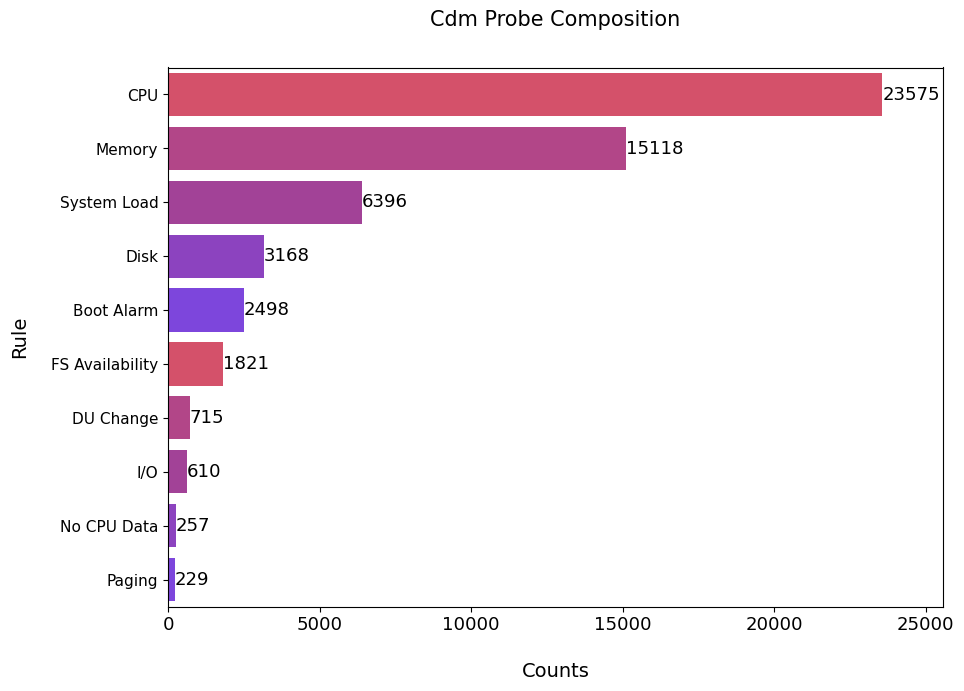

In [528]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections


cdm_df = dftest[dftest["probe_name"] == "cdm"]
cdm_df = cdm_df["rule"].value_counts().reset_index(name = "Counts")
cdm_df.rename(columns = {'index':'Rule'}, inplace = True)

plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("Cdm Probe Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = cdm_df)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = cdm_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('cdm.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### Sqlserver Composition

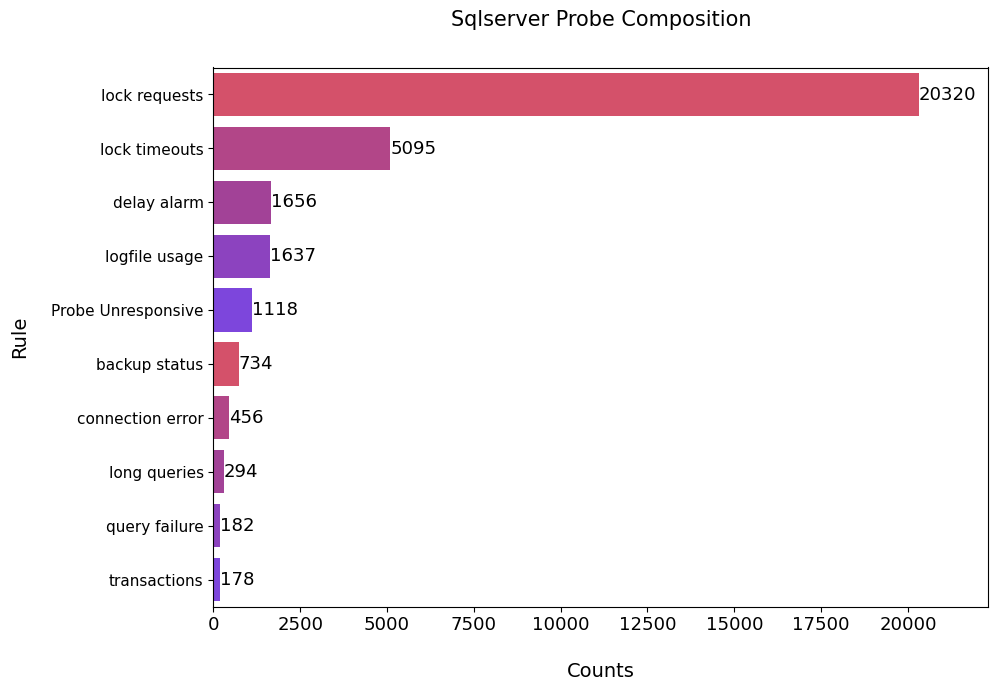

In [529]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections


sql_df = dftest[dftest["probe_name"] == "sqlserver"]

for index, row in sql_df.iterrows():
    supp = row["suppression_key"]
    rule = row["rule"]
    if rule == "Other":
        if pd.notna(supp):
            match = re.search(r"-(.*?)(?=[^a-z_\\])", supp, re.IGNORECASE)
            if match:
                sql_df.at[index, "rule"] = match.group(1)

sql_df = sql_df["rule"].value_counts().reset_index(name = "Counts")
sql_df.rename(columns = {'index':'Rule'}, inplace = True)    

sql_df.replace('_', ' ', regex = True, inplace = True)
sql_df = sql_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("Sqlserver Probe Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = sql_df)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = sql_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('sqlserver.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### SNMP Trap Composition

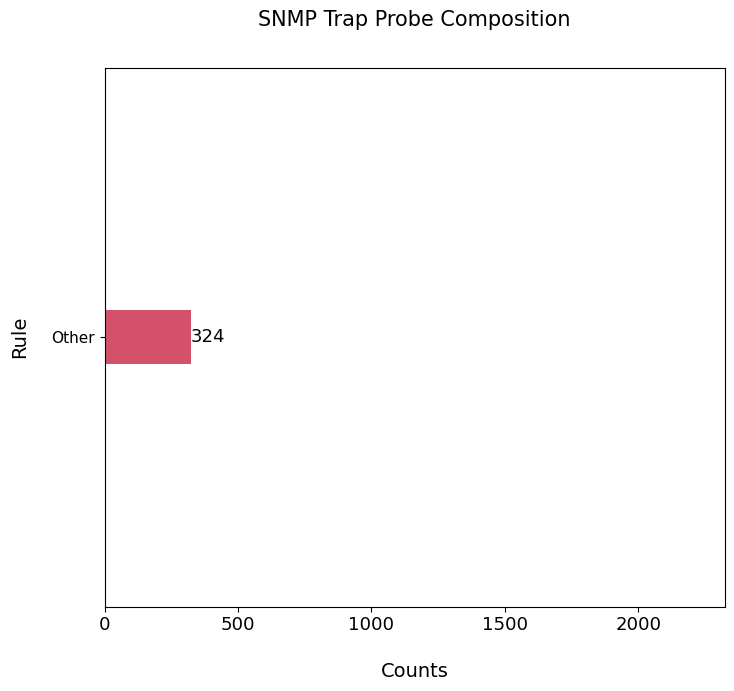

In [530]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

snmp_df = dftest[dftest["probe_name"] == "SNMP Trap"]
snmp_df = snmp_df["rule"].value_counts().reset_index(name = "Counts")
snmp_df.rename(columns = {'index':'Rule'}, inplace = True)
snmp_df = snmp_df.head(10)


plt.figure(figsize = (8, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("SNMP Trap Probe Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = snmp_df, width = 0.1)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = snmp_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('snmp.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### Discards Threshold Composition

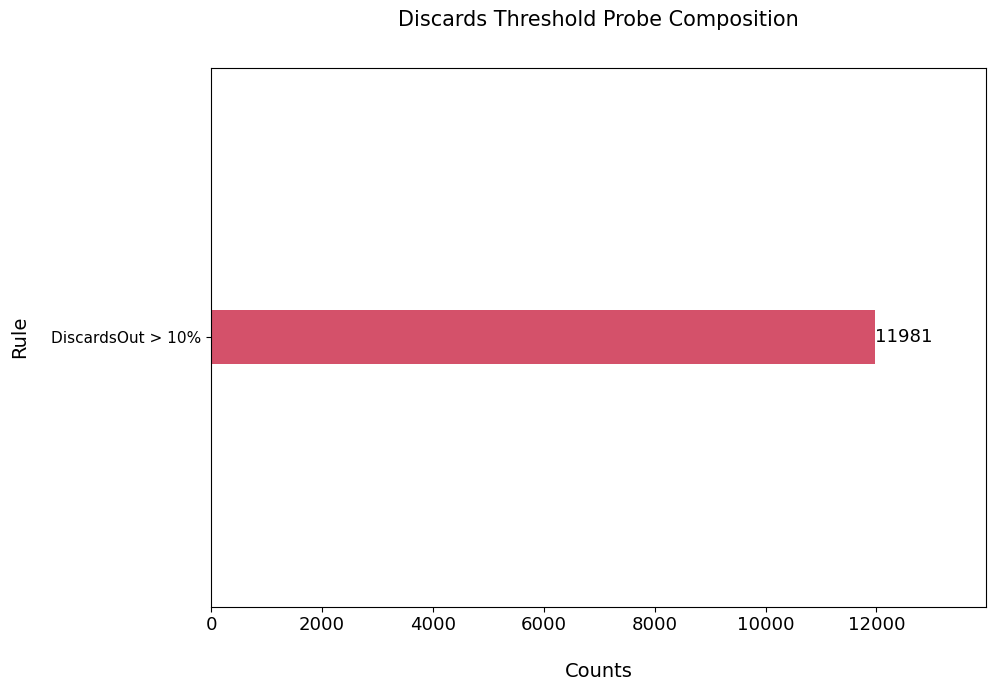

In [531]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

discards_df = dftest[dftest["probe_name"] == "Discards Threshold"]
discards_df = discards_df["rule"].value_counts().reset_index(name = "Counts")
discards_df.rename(columns = {'index':'Rule'}, inplace = True)
discards_df = discards_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("Discards Threshold Probe Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = discards_df, width = 0.1)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = discards_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('discards.png', 
           transparent=True, bbox_inches = 'tight')

plt.show()

### Checkpoint CPU Utilization_2 Composition

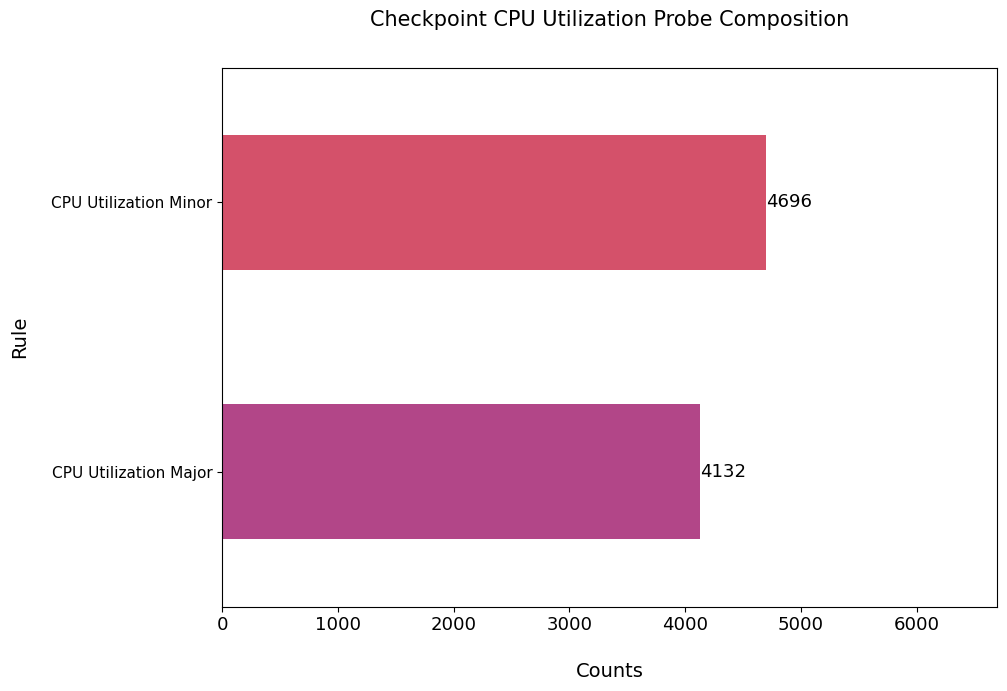

In [532]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

check_df = dftest[dftest["probe_name"] == "Checkpoint CPU Utilization_2"]
check_df = check_df["rule"].value_counts().reset_index(name = "Counts")
check_df.rename(columns = {'index':'Rule'}, inplace = True)
check_df = check_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("Checkpoint CPU Utilization Probe Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = check_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = check_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('checkpoint_cpu.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### Cmdb Counts 

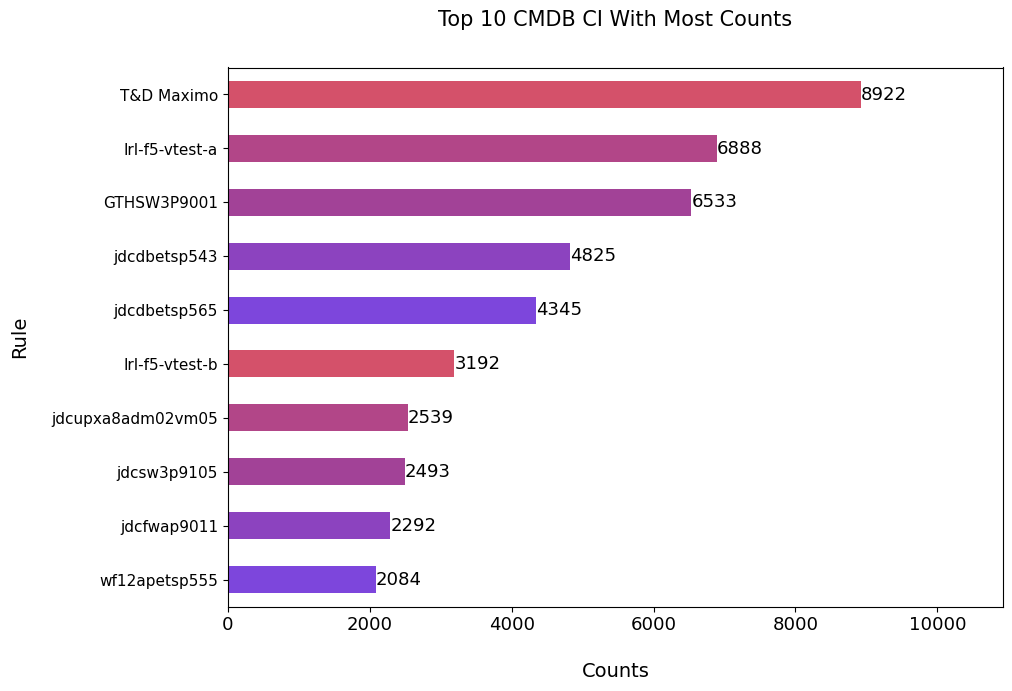

In [533]:
dftest["cmdb_ci"].value_counts()

import seaborn as sns
import matplotlib.pyplot as plt
import collections

cmdb_df = dftest["cmdb_ci"].value_counts().reset_index(name = "Counts")
cmdb_df.rename(columns = {'index':'Cmdb_ci'}, inplace = True)
cmdb_df = cmdb_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("Top 10 CMDB CI With Most Counts", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Cmdb_ci", data = cmdb_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = cmdb_df["Counts"].max() + 2000
ax1.set_xlim(0, max_counts)

plt.savefig('cmdb_ci.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### T & D Maximo Composition

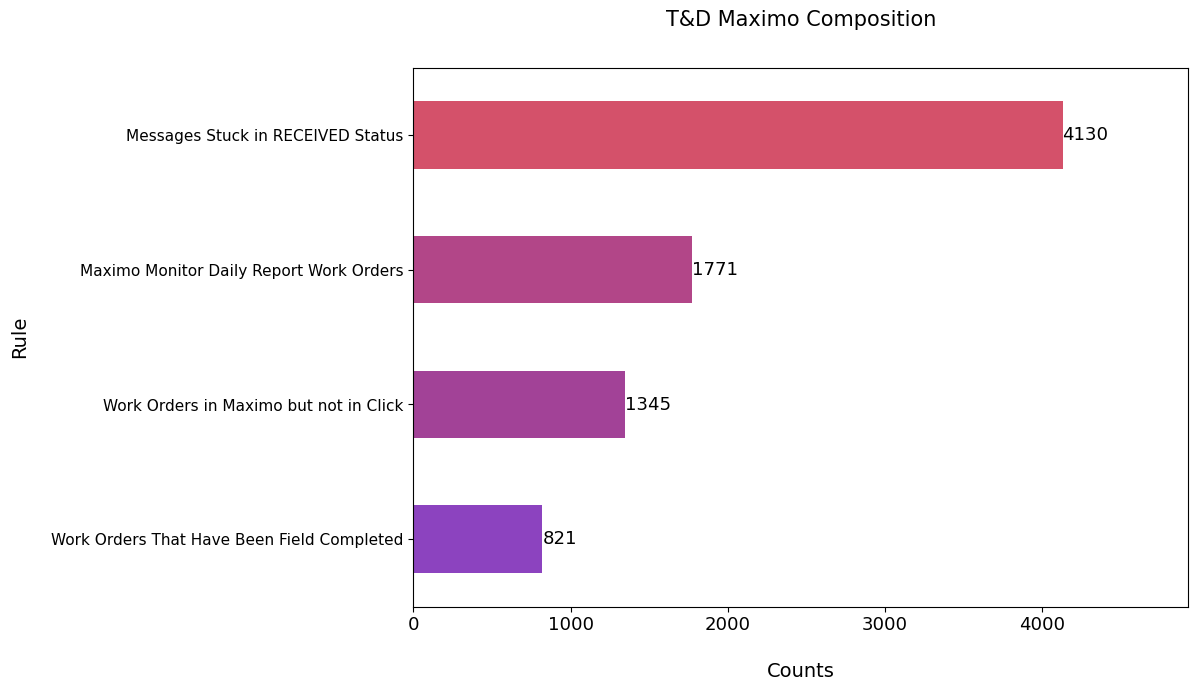

In [534]:
dftest["cmdb_ci"].value_counts()

import seaborn as sns
import matplotlib.pyplot as plt
import collections

maximo_df = dftest[dftest["cmdb_ci"] == "T&D Maximo"]
maximo_df = maximo_df["rule"].value_counts().reset_index(name = "Counts")
maximo_df.rename(columns = {'index':'Rule'}, inplace = True)
maximo_df = maximo_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("T&D Maximo Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = maximo_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = maximo_df["Counts"].max() + 800
ax1.set_xlim(0, max_counts)

plt.savefig('maximo.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### lrl-f5-vtest-a Composition

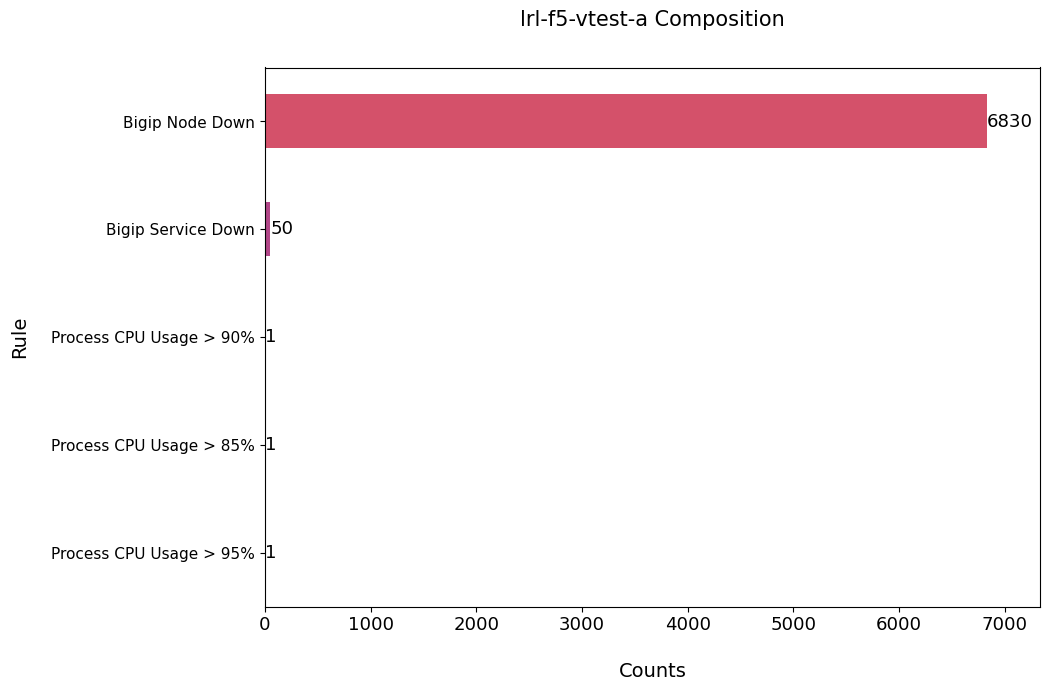

In [535]:
dftest[dftest["cmdb_ci"] == "lrl-f5-vtest-a"]["rule"].value_counts()
import seaborn as sns
import matplotlib.pyplot as plt
import collections

lrlf5_df = dftest[dftest["cmdb_ci"] == "lrl-f5-vtest-a"]
lrlf5_df = lrlf5_df["rule"].value_counts().reset_index(name = "Counts")
lrlf5_df.rename(columns = {'index':'Rule'}, inplace = True)
lrlf5_df = lrlf5_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("lrl-f5-vtest-a Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = lrlf5_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = lrlf5_df["Counts"].max() + 500
ax1.set_xlim(0, max_counts)

plt.savefig('lrlf5.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### GTHSW3P9001 Composition

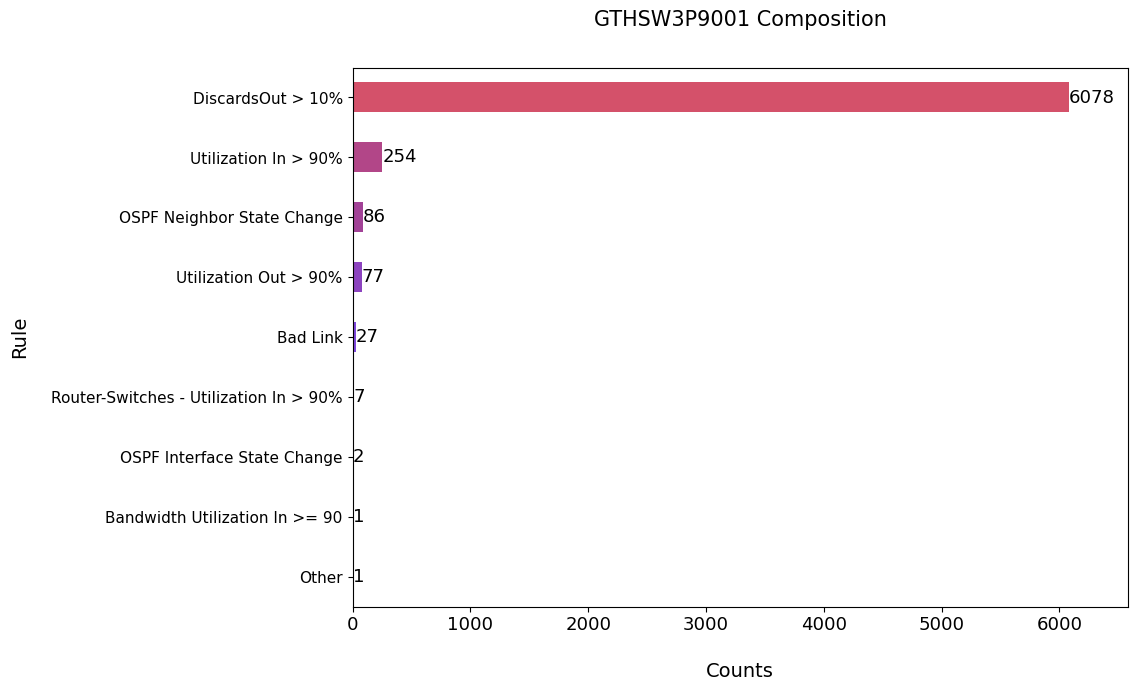

In [536]:

import seaborn as sns
import matplotlib.pyplot as plt
import collections

gths_df = dftest[dftest["cmdb_ci"] == "GTHSW3P9001"]
gths_df = gths_df["rule"].value_counts().reset_index(name = "Counts")
gths_df.rename(columns = {'index':'Rule'}, inplace = True)
gths_df = gths_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("GTHSW3P9001 Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = gths_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = gths_df["Counts"].max() + 500
ax1.set_xlim(0, max_counts)

plt.savefig('gths.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### jdcdbetsp543 Composition

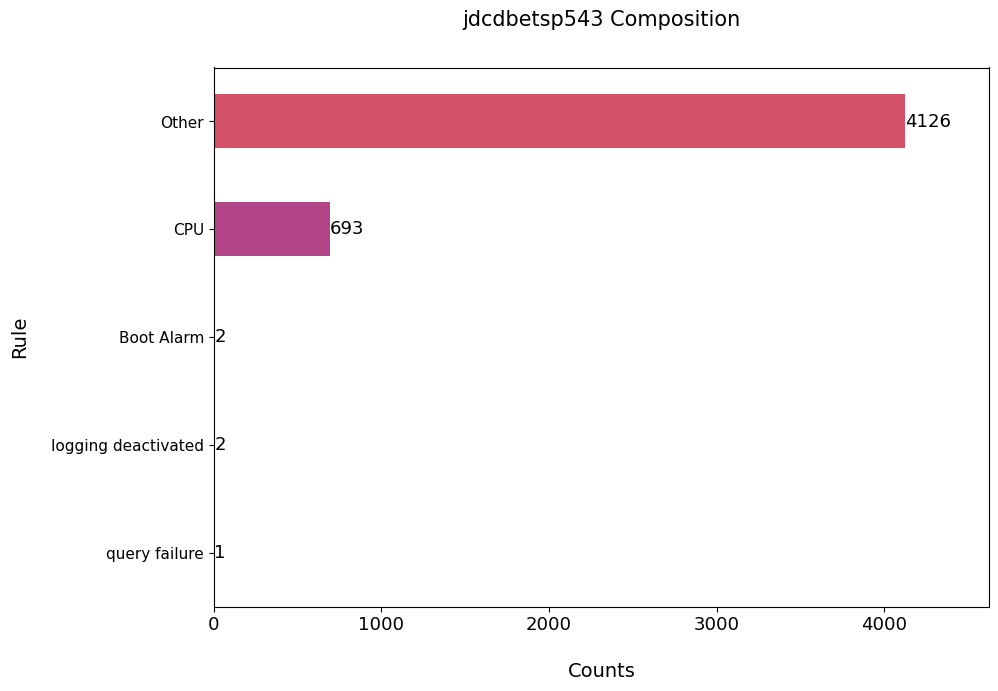

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

jdcd_df = dftest[dftest["cmdb_ci"] == "jdcdbetsp543"]
jdcd_df = jdcd_df["rule"].value_counts().reset_index(name = "Counts")
jdcd_df.rename(columns = {'index':'Rule'}, inplace = True)
jdcd_df = jdcd_df.head(10)


plt.figure(figsize = (10, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5", "#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))

plt.title("jdcdbetsp543 Composition", fontsize = 15, pad = 30)
ax1 = sns.barplot(x = "Counts", y = "Rule", data = jdcd_df, width = 0.5)
plt.xlabel("Counts", size = 14, labelpad = 20)
plt.ylabel("Rule", size = 14, labelpad = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 11)
ax1.bar_label(ax1.containers[0], size = 13)
max_counts = jdcd_df["Counts"].max() + 500
ax1.set_xlim(0, max_counts)

plt.savefig('jdcd.png', 
           transparent = True, bbox_inches = 'tight')

plt.show()

### Top 5 Caller Id With Most Counts

In [538]:
devices = ["DB  Notify", "DX AIOps", "Xerox User", "PeopleSoft HCM", "Itron Networked Solutions Support", "Dell OpenManage", "att alerts", "people softfin", "splunk integration",
           "tibco prod", "tibmft adm", "NuclearCyber ANO", "NuclearCyber ANO", "NuclearCyber RBS", "NuclearCyber WF3", "DX Netops", "Maximo Monitor"]

In [539]:
df_new_non_ppl = df_new["caller_id"].value_counts().reset_index(name = "Counts")
df_new_non_ppl.rename(columns = {'index':'Device'}, inplace = True)
df_new_non_ppl_5 = df_new_non_ppl.head(5)


<Figure size 900x700 with 0 Axes>

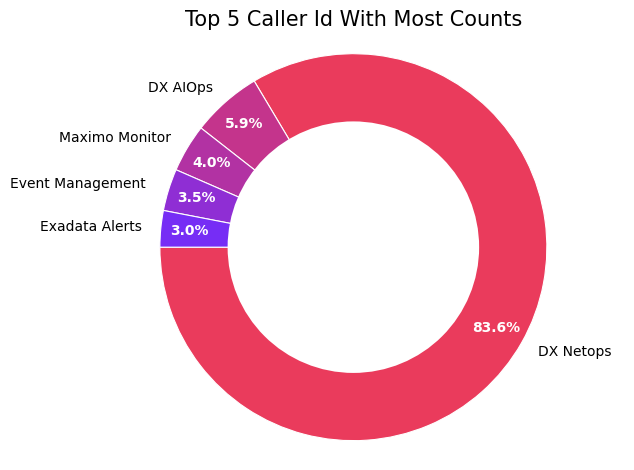

In [540]:
import seaborn as sns
import matplotlib.pyplot as plt
import collections

plt.figure(figsize = (9, 7))
colors = ["#EA3B5C", "#C4348C", "#B232A3", "#8F2ED4", "#762DF5"]
sns.set_palette(sns.color_palette(colors))


data = list(df_new_non_ppl_5["Counts"])

fig1, ax1 = plt.subplots()
_, _, autopcts = ax1.pie(data, colors = colors, labels = df_new_non_ppl_5["Device"], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.85,
        wedgeprops = {"edgecolor" : "white",
                      'linewidth': 0.8,
                      'antialiased': True})

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})
ax1.set_title('Top 5 Caller Id With Most Counts', fontdict = {'fontsize': 15})

#draw circle
centre_circle = plt.Circle((0,0),0.65,fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('piechart.png', 
           transparent = True, bbox_inches = 'tight')
plt.show()




### Memory and CPU Counts by Configuration Item

In [541]:
df_phys = df_new[df_new["suppression_key"] == "memory/physical"]
df_cpu = df_new[df_new["suppression_key"] == "cpu/total"]
df_phys_3 = df_phys["cmdb_ci"].value_counts().reset_index(name = "Counts").head(3)
df_cpu_3 = df_cpu["cmdb_ci"].value_counts().reset_index(name = "Counts").head(3)
df_phys_3["Type"] = "Physical Memory"
df_cpu_3["Type"] = "CPU"

df_PC = pd.concat([df_phys_3, df_cpu_3], ignore_index = True, sort = False)
df_PC.rename(columns = {'index':'cmdb_ci'}, inplace = True)

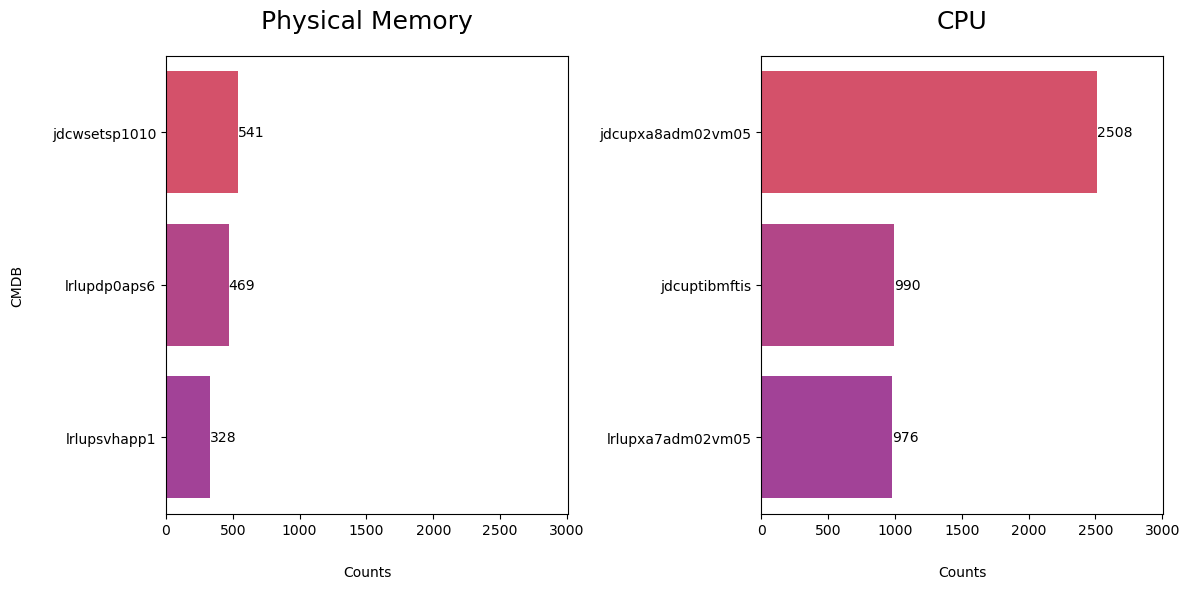

In [542]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), sharex = True)
sns.barplot(x = "Counts", y = "cmdb_ci", data = df_PC[df_PC["Type"] == "Physical Memory"], ax = ax1)
ax1.set_title("Physical Memory", pad = 20, fontsize = 18)
ax1.set_xlabel("Counts", labelpad = 20)
ax1.set_ylabel("CMDB", labelpad = 20)
ax1.bar_label(ax1.containers[0])

sns.barplot(x = "Counts", y = "cmdb_ci", data = df_PC[df_PC["Type"] == "CPU"], ax = ax2)
ax2.set_title("CPU", pad = 20, fontsize = 18)
ax2.set_xlabel("Counts", labelpad = 20)
ax2.set_ylabel("", labelpad = 20)
ax2.bar_label(ax2.containers[0])

max_counts = df_PC["Counts"].max() + 500
ax1.set_xlim(0, max_counts)
ax2.set_xlim(0, max_counts)

plt.tight_layout()
# for ax in p2.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha = "right")
plt.savefig('memory.png', 
           transparent = True, bbox_inches = 'tight')
plt.show()